# Highlight&Summarize data analysis

This notebook has routines for loading the outputs of our experiments, which are found in `results/`,
and for reproducing all the plots and numbers that are contained in the paper.

In [1]:
import os
import tiktoken
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fastchat.serve.monitor.elo_analysis import compute_elo

from pathlib import Path
from highlight_summarize.data import load_dataset
from highlight_summarize.utils import NOANSWER_PRED
from utils import load_all_results

In [2]:
RESULTS_DIR = "results/"
PALETTE = sns.color_palette("colorblind")
sns.set_palette(PALETTE)

PRETTY_NAMES = {
    "hs": "H&S",
    "highlighter": "Highlighter",
    "neither": "Neither",
    "tie": "Tie",
    "repliqa_3": "RepliQA",
    "bioasq": "BioASQ",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini": "H&S Baseline",
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Structured Highlighter",
    "HSSpanHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Span Highlighter",
    "HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Two Steps Highlighter",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini": "H&S BERT Extractor (SQuAD2)",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini": "H&S BERT Extractor (RepliQA)",
    "QAEvaluator-gpt-4.1-mini": "Vanilla RAG",
    "PollMultihopCorrectness-gpt-4.1-mini_correctness_rating": "Poll Multihop Correctness",
    "ReliableCIRelevance-gpt-4.1-mini_quality_rating": "Reliable CI Relevance",
    "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating": "MTBench Chat Bot Response Quality",
    "LLMJudgeStructured-gpt-4.1-mini_rating": "LLM Judge Structured",
}

def to_latex(df, columns, sort_by=None, ascending=False):
    sort_by = sort_by or columns[0]
    tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
        .sort_values(sort_by, ascending=ascending) \
        .reset_index().rename(columns={"run_id": "Run ID"}) \
        .to_latex(float_format="%.2f", index=False, formatters={"Run ID": lambda x: PRETTY_NAMES.get(x, x).replace("&", "\\&")})
    print(tex.replace("_", "\\_"))

# Main experiments

These are based on results obtained either directly from our repository or after running `run_experiments.py.

## Data (two loading procedures)

Select the most appropriate procedure depending on how you generated the data.

1) From Parquet (default): you just cloned the repo.

The `.parquet` files under `results/` in the repository only store the output of our experiments, and not the remaining data from the HF datasets.

**Steps**:
- Remember to `git lfs pull --exclude=""` before running this.
- leave `LOAD_RESULTS_FROM = "parquet"` in the cell below.

2) From the results/**jsonl files.

Use this option if you have re-run the experiments via `run_experiments.py`, maybe with your own configuration.

This will only work if you have re-run the experiments via run_experiments.py. In this case, you should not execute the above cell.

**Steps**:
- Your experiments using `run_experiments.py` must have finished running (take a look at README.md for instructions).
- Uncomment `LOAD_RESULTS_FROM = "jsonl"` in the next cell.

In [3]:
LOAD_RESULTS_FROM = "parquet"
# LOAD_RESULTS_FROM = "jsonl"

if LOAD_RESULTS_FROM == "parquet":
    results_df = {}
    for dataset in ["repliqa_3", "bioasq"]:
        results_df[dataset] = pd.read_parquet(Path(RESULTS_DIR) / Path(dataset) / f"{dataset}_results_processed.parquet")
        # Merge with the HuggingFace dataset.
        hf_data = load_dataset(dataset)
        hf_df = hf_data.to_pandas()
        # Merge the dataframes on question_id
        # This will automatically replicate hf_data rows for each method in new_results_df
        question_id = "question_id" if "question_id" in hf_df.columns else "id"
        results_df[dataset] = results_df[dataset].merge(
            hf_df, 
            on=question_id, 
            how="left"
        )
else:
    results_df = load_all_results(RESULTS_DIR)
    results_df = {k: v.to_pandas() for k, v in results_df.items()}

## Metrics

In [4]:
enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def adlakha_precision_recall(gold_answers, gold_passages, answers_pred):
    """K-precision and Recall as defined in Adlakha et al. (2024).

    K-precision measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.

    Recall measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    precisions = []
    recalls = []
    for answer, passage, answer_pred in zip(gold_answers, gold_passages, answers_pred):
        if answer == NOANSWER_PRED:
            raise ValueError("Reference answer is NOANSWER_PRED.")

        if answer_pred == NOANSWER_PRED or not answer_pred or pd.isnull(answer_pred):
            precisions.append(0.0)
            recalls.append(0.0)
            continue
        
        # Precision
        passage_tokens = set(enc.encode(passage))
        answer_pred_tokens = set(enc.encode(answer_pred))
        common_tokens = passage_tokens.intersection(answer_pred_tokens)
        precision = len(common_tokens) / len(answer_pred_tokens)
        precisions.append(precision)

        # Recall
        answer_tokens = set(enc.encode(answer))
        common_tokens = answer_tokens.intersection(answer_pred_tokens)
        recall = len(common_tokens) / len(answer_tokens)
        recalls.append(recall)

    return precisions, recalls

## Evaluating H&S components

### How good are the highlighters? (Table 6, Figure 8)

We compare the highlighter implementations.
We use `long_answer`, so we can only do this for the RepliQA dataset.

In [5]:
df = results_df["repliqa_3"]

# Filter out no-answer predictions and QAEvaluator pipeline.
df = df[df.pipeline != "QAEvaluator"]
df = df[df.answer != NOANSWER_PRED]
# Check that the long answer is accurate.
df = df[df.long_answer != ""]
df = df[df.apply(lambda x: x["long_answer"] in x["document_extracted"], axis=1)]


# Adlakha precision and recall.
df["highlighter_precision"], df["highlighter_recall"] = adlakha_precision_recall(
    df["long_answer"],
    df["long_answer"],
    df["highlighter_extracted"]
)

print("% K-precision/recall")
to_latex(df, ["highlighter_precision", "highlighter_recall"])

# Worst examples (that aren't NaN).
for run_id in df.run_id.unique():
    run_id_df = df[df.run_id == run_id]
    run_id_df = run_id_df[~pd.isnull(run_id_df.highlighter_extracted)]
    if len(run_id_df) == 0:
        continue
    worst_examples = run_id_df.sort_values("highlighter_precision").head(1)
    print(f"Worst examples for {run_id}:")
    for _, row in worst_examples.iterrows():
        print(f"  - {row['highlighter_precision']:.4f}")
        print(f"    Long answer: {row['long_answer']}")
        print(f"    Extracted: {row['highlighter_extracted']}")
    print("=" * 80)

% K-precision/recall
\begin{tabular}{lrr}
\toprule
Run ID & highlighter\_precision & highlighter\_recall \\
\midrule
H\&S Baseline & 0.85 & 0.66 \\
H\&S Span Highlighter & 0.84 & 0.73 \\
H\&S Structured Highlighter & 0.84 & 0.76 \\
H\&S Two Steps Highlighter & 0.82 & 0.77 \\
H\&S BERT Extractor (RepliQA) & 0.80 & 0.36 \\
H\&S BERT Extractor (SQuAD2) & 0.55 & 0.22 \\
\bottomrule
\end{tabular}

Worst examples for HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini:
  - 0.0000
    Long answer: Secure network infrastructure extends beyond hardware and software; it also includes empowering the users. Voicing a striking point on January 20, 2024, cybersecurity educator Michael Chen stated, "Teachers and students are the frontline defenders of our educational networks. Teaching them about safe online behaviors and threat recognition is just as important as the technology we deploy." Programs like cybersecurity awareness training have become commonplace, creating a more knowledgeable school comm

/tmp/ipykernel_3084304/3429809249.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


\begin{tabular}{lrrrr}
\toprule
Run ID & total & passage\_matches\_highlighted & passage\_is\_superset & passage\_is\_substring \\
\midrule
H\&S BERT Extractor (RepliQA) & 6671.00 & 139.00 & 6514.00 & 18.00 \\
H\&S Baseline & 6502.00 & 1246.00 & 4615.00 & 641.00 \\
H\&S Span Highlighter & 6178.00 & 988.00 & 3737.00 & 1453.00 \\
H\&S Two Steps Highlighter & 4034.00 & 636.00 & 2537.00 & 861.00 \\
H\&S BERT Extractor (SQuAD2) & 3703.00 & 4.00 & 3695.00 & 4.00 \\
H\&S Structured Highlighter & 3608.00 & 535.00 & 2313.00 & 760.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3084304/4263487677.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis = df.groupby("run_id").apply(
/tmp/ipykernel_3084304/3429809249.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


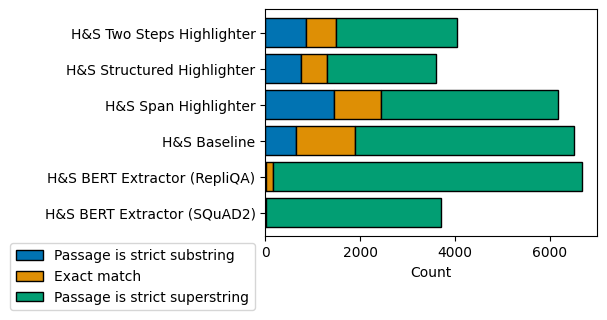

In [6]:
# Remove the cases where long_answer isn't a substring of the document_extracted.
df = df[df.apply(lambda x: x["long_answer"] in x["document_extracted"] and pd.notnull(x["highlighter_extracted"]), axis=1)]

df["passage_matches_highlighted"] = df.apply(
    lambda x: x["highlighter_extracted"].strip() == x["long_answer"].strip(),
    axis=1
)
df["passage_is_substring"] = df.apply(
    lambda x: (x["long_answer"] in x["highlighter_extracted"]) and (x["highlighter_extracted"].strip() != x["long_answer"].strip()),
    axis=1
)
df["passage_is_superset"] = df.apply(
    lambda x: (x["highlighter_extracted"] in x["long_answer"]) and (x["highlighter_extracted"].strip() != x["long_answer"].strip()),
    axis=1
)

df_analysis = df.groupby("run_id").apply(
    lambda x: pd.Series({
        "passage_matches_highlighted": x["passage_matches_highlighted"].sum(),
        "passage_is_substring": x["passage_is_substring"].sum(),
        "passage_is_superset": x["passage_is_superset"].sum(),
        "total": x["passage_matches_highlighted"].sum() + x["passage_is_substring"].sum() + x["passage_is_superset"].sum()
    })
).reset_index()
to_latex(df_analysis, columns=["total", "passage_matches_highlighted", "passage_is_superset", "passage_is_substring"],
    sort_by="total", ascending=False
)

df_analysis["run_id"] = df_analysis["run_id"].map(lambda x: PRETTY_NAMES.get(x, x))
# Rename columns.
df_analysis.rename(columns={
    "passage_matches_highlighted": "Exact match",
    "passage_is_superset": "Passage is strict superstring",
    "passage_is_substring": "Passage is strict substring"
}, inplace=True)
ax = df_analysis.set_index("run_id")[["Passage is strict substring", "Exact match", "Passage is strict superstring"]].plot(
    kind="barh",
    stacked=True,
    width=0.8,
    edgecolor="black",
    figsize=(6, 3),
)
plt.xlabel("Count")
plt.ylabel("")
plt.tight_layout()
plt.legend(bbox_to_anchor=(-0.01, 0))

### Can the summarizer guess what was the question? (Table 10, Figure 9)

In [7]:
for dataset_name in ["repliqa_3", "bioasq"]:
    df = results_df[dataset_name].copy()
    
    # Filter out no-answer predictions and QAEvaluator pipeline.
    df = df[df.pipeline != "QAEvaluator"]
    df = df[df.answer != NOANSWER_PRED]

    # Remove cases where the summarizer just got bad input.
    # (We leave those cases for the highlighter evaluation.)
    df = df[df.highlighter_extracted != ""]
    df = df[~pd.isnull(df.highlighter_extracted)]
    # We also discard cases where the summarizer guessed an empty question.
    # In those cases, the H&S pipeline should return "NOANSWER_PRED".
    df = df[~pd.isnull(df.summarizer_llm_guessed_questions)]
    
    # Reset index to ensure clean DataFrame
    df = df.reset_index(drop=True)

    print(f"Processing dataset: {dataset_name}")
    
    # Compute metrics for each guessed question in the list
    max_precisions = []
    max_recalls = []
    best_guess = []
    
    for idx, row in df.iterrows():
        guessed_questions = row["summarizer_llm_guessed_questions"]
        question = row["question"]
        
        row_precisions = []
        row_recalls = []
        
        for gq in guessed_questions:
            if gq and not pd.isnull(gq):
                prec, rec = adlakha_precision_recall([question], [question], [gq])
                row_precisions.append(prec[0])
                row_recalls.append(rec[0])
            else:
                row_precisions.append(0.0)
                row_recalls.append(0.0)

        idx_max = np.argmax(row_precisions)
        max_precisions.append(row_precisions[idx_max])
        max_recalls.append(row_recalls[idx_max])
        best_guess.append(guessed_questions[idx_max])
    
    df = df.copy()  # Ensure we can assign new columns
    df["guessed_question_precision_max"] = max_precisions
    df["guessed_question_recall_max"] = max_recalls
    df["guessed_question_best_guess"] = best_guess
    
    # Print K-precision/recall stats (max)
    print("% Max K-precision/recall")
    to_latex(df, ["guessed_question_precision_max", "guessed_question_recall_max"], 
             sort_by="guessed_question_precision_max", ascending=False)

    # Iterate through all methods
    for method in df.run_id.unique():
        df_method = df[df.run_id == method]

        idx_sorted = np.argsort(df_method["guessed_question_precision_max"].values)
        df_sorted = df_method.iloc[idx_sorted]
        
        # Create a clean label from the method name
        method_label = method.replace("-", "_").replace(".", "_")

        # Print table for this method
        print(f"\\begin{{table}}[h]")
        print(f"\\caption{{Best and worst question guesses by the summarizer of the {PRETTY_NAMES.get(method, method)} pipeline on {PRETTY_NAMES.get(dataset_name, dataset_name)}.}}")
        print(f"\\label{{tab:guesses-{dataset_name}-{method_label}}}")
        print("\\begin{tabularx}{\\linewidth}{cXX}")
        print("\\toprule")
        print("Score & Real question & Guessed question \\\\")
        print("\\midrule")
        # Best 3
        for _, row in df_sorted.tail(3).iterrows():
            score = f"{row['guessed_question_precision_max']:.2f}"
            real_q = row['question'].replace("&", "\\&").replace("%", "\\%").replace("_", "\\_").replace("#", "\\#")
            guessed_q = row['guessed_question_best_guess'].replace("&", "\\&").replace("%", "\\%").replace("_", "\\_")
            print(f"{score} & {real_q} & {guessed_q} \\\\")
        print("\\midrule")
        # Worst 3
        for _, row in df_sorted.head(3)[::-1].iterrows():
            score = f"{row['guessed_question_precision_max']:.2f}"
            real_q = row['question'].replace("&", "\\&").replace("%", "\\%").replace("_", "\\_").replace("#", "\\#")
            guessed_q = row['guessed_question_best_guess'].replace("&", "\\&").replace("%", "\\%").replace("_", "\\_")
            print(f"{score} & {real_q} & {guessed_q} \\\\")
        print("\\bottomrule")
        print("\\end{tabularx}")
        print("\\end{table}")
        print()

    print("-"*80)

Processing dataset: repliqa_3
% Max K-precision/recall
\begin{tabular}{lrr}
\toprule
Run ID & guessed\_question\_precision\_max & guessed\_question\_recall\_max \\
\midrule
H\&S Span Highlighter & 0.70 & 0.46 \\
H\&S Structured Highlighter & 0.69 & 0.47 \\
H\&S Two Steps Highlighter & 0.69 & 0.47 \\
H\&S Baseline & 0.68 & 0.45 \\
H\&S BERT Extractor (RepliQA) & 0.58 & 0.35 \\
H\&S BERT Extractor (SQuAD2) & 0.45 & 0.26 \\
\bottomrule
\end{tabular}

\begin{table}[h]
\caption{Best and worst question guesses by the summarizer of the H&S Structured Highlighter pipeline on RepliQA.}
\label{tab:guesses-repliqa_3-HSStructuredHighlighter_gpt_4_1_mini_gpt_4_1_mini}
\begin{tabularx}{\linewidth}{cXX}
\toprule
Score & Real question & Guessed question \\
\midrule
1.00 & Who introduced the 'farm to table' cooking classes as part of the NutriSmart program and when were these classes started? & Who introduced the 'farm to table' cooking classes and when? \\
1.00 & What is the cultural significance of H

/tmp/ipykernel_3084304/3429809249.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


Processing dataset: bioasq
% Max K-precision/recall
\begin{tabular}{lrr}
\toprule
Run ID & guessed\_question\_precision\_max & guessed\_question\_recall\_max \\
\midrule
H\&S BERT Extractor (RepliQA) & 0.55 & 0.50 \\
H\&S Baseline & 0.55 & 0.56 \\
H\&S Structured Highlighter & 0.54 & 0.57 \\
H\&S Span Highlighter & 0.53 & 0.55 \\
H\&S Two Steps Highlighter & 0.52 & 0.57 \\
H\&S BERT Extractor (SQuAD2) & 0.37 & 0.38 \\
\bottomrule
\end{tabular}

\begin{table}[h]
\caption{Best and worst question guesses by the summarizer of the H&S Baseline pipeline on BioASQ.}
\label{tab:guesses-bioasq-HSBaseline_gpt_4_1_mini_gpt_4_1_mini}
\begin{tabularx}{\linewidth}{cXX}
\toprule
Score & Real question & Guessed question \\
\midrule
1.00 & What is known about autosomal dominant Alzheimer’s disease? & What is autosomal dominant Alzheimer disease? \\
1.00 & What is ectopia lentis? & What is ectopia lentis? \\
1.00 & What is ferroptosis? & What is ferroptosis? \\
\midrule
0.00 & Describe ANTISOMA & What i

/tmp/ipykernel_3084304/3429809249.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


Text(0.5, 0, 'Guessed quession F1')

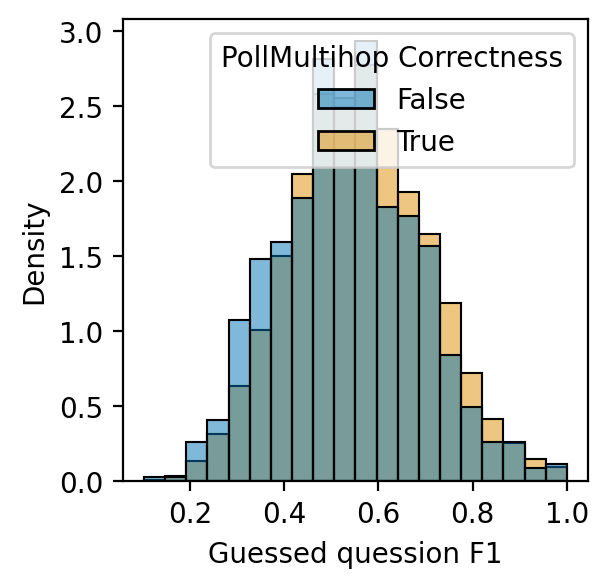

In [8]:
df = results_df["repliqa_3"]
dfhs = df[df.pipeline == "HSTwoStepsHighlighter"]
dfhs = dfhs[pd.notnull(dfhs.summarizer_llm_guessed_questions)]
dfhs = dfhs[dfhs.summarizer_llm_guessed_questions.apply(lambda x: len(x) > 0 if isinstance(x, np.ndarray) else False)]
dfhs = dfhs[dfhs.answer != NOANSWER_PRED]
dfhs = dfhs.reset_index(drop=True)

# Compute best precision and recall across all guessed questions per row
best_precisions = []
best_recalls = []
best_f1s = []
best_guess = []
worst_precisions = []
worst_recalls = []
worst_f1s = []
worst_guess = []
for _, row in dfhs.iterrows():
    question = row["question"]
    guessed_questions = row["summarizer_llm_guessed_questions"]
    
    row_f1s = []
    row_precs = []
    row_recs = []
    for gq in guessed_questions:
        prec_list, rec_list = adlakha_precision_recall([question], [question], [gq])
        p, r = prec_list[0], rec_list[0]
        row_precs.append(p)
        row_recs.append(r)
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
        row_f1s.append(f1)
    
    # Find the index of the best F1 and use that question's precision/recall
    best_idx = np.argmax(row_f1s)
    best_precisions.append(row_precs[best_idx])
    best_recalls.append(row_recs[best_idx])
    best_f1s.append(row_f1s[best_idx])
    best_guess.append(guessed_questions[best_idx])
    # Worst.
    worst_idx = np.argmin(row_f1s)
    worst_precisions.append(row_precs[worst_idx])
    worst_recalls.append(row_recs[worst_idx])
    worst_f1s.append(row_f1s[worst_idx])
    worst_guess.append(guessed_questions[worst_idx])

dfhs = dfhs.copy()
dfhs["guessed_question_precision"] = best_precisions
dfhs["guessed_question_recall"] = best_recalls
dfhs["guessed_question_f1"] = best_f1s
dfhs["best_guessed_question"] = best_guess
dfhs["PollMultihop Correctness"] = dfhs["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"]
plt.figure(figsize=(3, 3), dpi=200)
ax = sns.histplot(
    data=dfhs,
    x="guessed_question_f1",
    hue="PollMultihop Correctness",
    stat="density",
    common_norm=False,
    bins=20,
)
plt.xlabel("Guessed quession F1")

In [9]:
from scipy.stats import pearsonr

pearsonr(dfhs["guessed_question_precision"], dfhs["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"].astype(float))

PearsonRResult(statistic=np.float64(0.04157730925902129), pvalue=np.float64(7.351144592540447e-07))

### The importance of a generative summarizer (Figure 7)

Processing file: comparison-HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini-highlighter_vs_hs.jsonl
Dataset: repliqa_3
\begin{tabular}{l|c}
\toprule
Preference & Count \\
\midrule
Tie & 0.4618 \\
H&S & 0.3867 \\
Highlighter & 0.0778 \\
Neither & 0.0737 \\
\bottomrule
\end{tabular}
Processing file: comparison-HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini-highlighter_vs_hs.jsonl
Dataset: bioasq
\begin{tabular}{l|c}
\toprule
Preference & Count \\
\midrule
H&S & 0.6652 \\
Tie & 0.2060 \\
Neither & 0.1051 \\
Highlighter & 0.0237 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_3084304/4225235597.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis = df.groupby("dataset_name").apply(


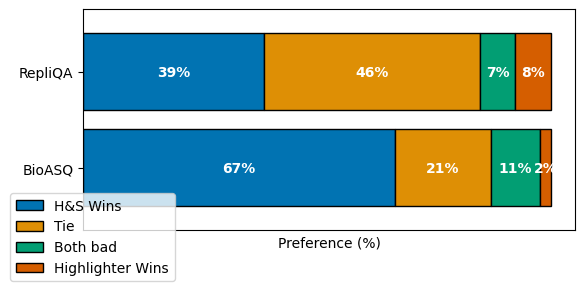

In [10]:
pipeline = "HSTwoStepsHighlighter"

to_cat = []
for dataset_name in ["repliqa_3", "bioasq"]:
    dataset_folder = f"{RESULTS_DIR}/{dataset_name}/"
    for fname in os.listdir(dataset_folder):
        if not fname.startswith(f"comparison-{pipeline}"):
            continue
        if not fname.endswith("highlighter_vs_hs.jsonl"):
            continue
        print(f"Processing file: {fname}")
        df = pd.read_json(os.path.join(dataset_folder, fname), lines=True)
        df["preference"] = df.preference.map(lambda x: PRETTY_NAMES.get(x, x))

        # As a latex table.
        print(f"Dataset: {dataset_name}")
        print("\\begin{tabular}{l|c}")
        print("\\toprule")
        print("Preference & Count \\\\")
        print("\\midrule")
        for pref, count in df.value_counts("preference").items():
            # Normalize by the total number of samples.
            print(f"{pref} & {count / len(df):.4f} \\\\")
        print("\\bottomrule")
        print("\\end{tabular}")
    
    df["dataset_name"] = dataset_name
    to_cat.append(df)

df = pd.concat(to_cat, ignore_index=True)
df_analysis = df.groupby("dataset_name").apply(
    lambda x: pd.Series({
        "H&S Wins": (x.preference == "H&S").mean(),
        "Tie": ((x.preference == "Tie")).mean(),
        "Both bad": (x.preference == "Neither").mean(),
        "Highlighter Wins": (x.preference == "Highlighter").mean(),
    })
).reset_index()

df_analysis["dataset_name"] = df_analysis["dataset_name"].map(PRETTY_NAMES)
plot_data = df_analysis.set_index("dataset_name")[["H&S Wins", "Tie", "Both bad", "Highlighter Wins"]]
ax = plot_data.plot(
    kind="barh",
    stacked=True,
    width=0.8,
    edgecolor="black",
    figsize=(6, 3),
)
plt.xlabel("Preference (%)")
plt.ylabel("")
plt.xticks([])
plt.legend(bbox_to_anchor=(0.2, 0.2))
plt.tight_layout()

# Add % labels to each bar segment
for i, (idx, row) in enumerate(plot_data.iterrows()):
    left = 0
    for col in plot_data.columns:
        value = row[col]
        if value > 0.01:  # Only label if >1%
            ax.text(left + value / 2, i, f"{value*100:.0f}%", va='center', ha='center', color="white", fontsize=10, fontweight="bold")
        left += value

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

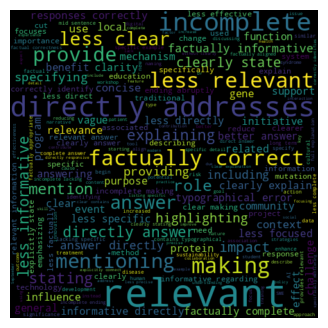

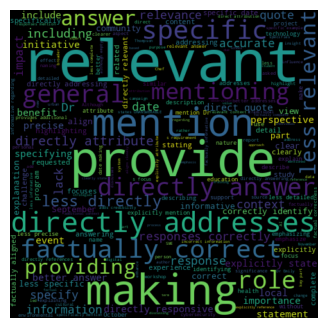

In [11]:
from wordcloud import WordCloud

text = "\n".join(df[df.preference == "H&S"].explanation.unique())
text = text.replace("Response", "").replace("question", "")
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
plt.figure(figsize=(4, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

text = "\n".join(df[df.preference == "Highlighter"].explanation.unique())
text = text.replace("Response", "").replace("question", "")
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
plt.figure(figsize=(4, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Full pipelines comparison: vanilla vs HS RAG

### K-precision and recall (Table 4)

In [12]:
# Collect results for all datasets
all_dataset_results = {}

for dataset_name in ["repliqa_3", "bioasq"]:
    dataset_results = results_df[dataset_name]
    # Remove unanswerable.
    dataset_results = dataset_results[dataset_results.answer != NOANSWER_PRED]

    df = dataset_results[dataset_results.answer != NOANSWER_PRED]
    if "long_answer" in df.columns:
        df = df[df.long_answer != ""]
        # Use list comprehension instead of apply for faster substring check
        mask = [la in doc for la, doc in zip(df["long_answer"], df["document_extracted"])]
        df = df[mask]

        df["ref_passage_precision"], df["ref_answer_recall"] = adlakha_precision_recall(
            df["answer"],
            df["long_answer"],
            df["answer_pred"]
        )
    else:
        df["ref_passage_precision"], df["ref_answer_recall"] = adlakha_precision_recall(
            df["answer"],
            df["answer"],
            df["answer_pred"]
        )
    
    # Aggregate by run_id
    agg_df = df.groupby("run_id").agg({
        "ref_passage_precision": "mean",
        "ref_answer_recall": "mean"
    }).reset_index()
    agg_df = agg_df.sort_values("ref_passage_precision", ascending=False)
    
    all_dataset_results[dataset_name] = agg_df

# Print combined LaTeX table
print("\\begin{table}[h]")
print("    \\caption{K-precision and recall of the predicted answers against the reference passage and answer.}")
print("    \\label{tab:kprec-recall}")
print("    \\begin{tabular}{llrr}")
print("    \\toprule")
print("    & Pipeline & K-Precision & Recall \\\\")
print("    \\midrule")

for i, dataset_name in enumerate(["repliqa_3", "bioasq"]):
    agg_df = all_dataset_results[dataset_name]
    n_models = len(agg_df)
    dataset_pretty = PRETTY_NAMES.get(dataset_name, dataset_name)
    
    print(f"    \\multirow{{{n_models}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{dataset_pretty}}}}}")
    
    for j, (_, row) in enumerate(agg_df.iterrows()):
        pipeline_name = PRETTY_NAMES.get(row["run_id"], row["run_id"]).replace("&", "\\&")
        precision = row["ref_passage_precision"]
        recall = row["ref_answer_recall"]
        print(f"    & {pipeline_name} & {precision:.2f} & {recall:.2f} \\\\")
    
    if i < 1:  # Add midrule between datasets
        print("    \\midrule")

print("    \\bottomrule")
print("    \\end{tabular}")
print("\\end{table}")

\begin{table}[h]
    \caption{K-precision and recall of the predicted answers against the reference passage and answer.}
    \label{tab:kprec-recall}
    \begin{tabular}{llrr}
    \toprule
    & Pipeline & K-Precision & Recall \\
    \midrule
    \multirow{7}{*}{\rotatebox[origin=c]{90}{RepliQA}}
    & Vanilla RAG & 0.76 & 0.78 \\
    & H\&S Structured Highlighter & 0.70 & 0.65 \\
    & H\&S Span Highlighter & 0.69 & 0.64 \\
    & H\&S Baseline & 0.69 & 0.63 \\
    & H\&S Two Steps Highlighter & 0.69 & 0.64 \\
    & H\&S BERT Extractor (RepliQA) & 0.63 & 0.39 \\
    & H\&S BERT Extractor (SQuAD2) & 0.44 & 0.22 \\
    \midrule
    \multirow{7}{*}{\rotatebox[origin=c]{90}{BioASQ}}
    & Vanilla RAG & 0.55 & 0.44 \\
    & H\&S Baseline & 0.37 & 0.42 \\
    & H\&S Structured Highlighter & 0.37 & 0.44 \\
    & H\&S Two Steps Highlighter & 0.35 & 0.44 \\
    & H\&S BERT Extractor (RepliQA) & 0.27 & 0.22 \\
    & H\&S BERT Extractor (SQuAD2) & 0.22 & 0.16 \\
    & H\&S Span Highlighter & 0.19

### LLM as a judge (Figures 5)

Dataset: repliqa_3


Dataset: bioasq


/tmp/ipykernel_3084304/218732885.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


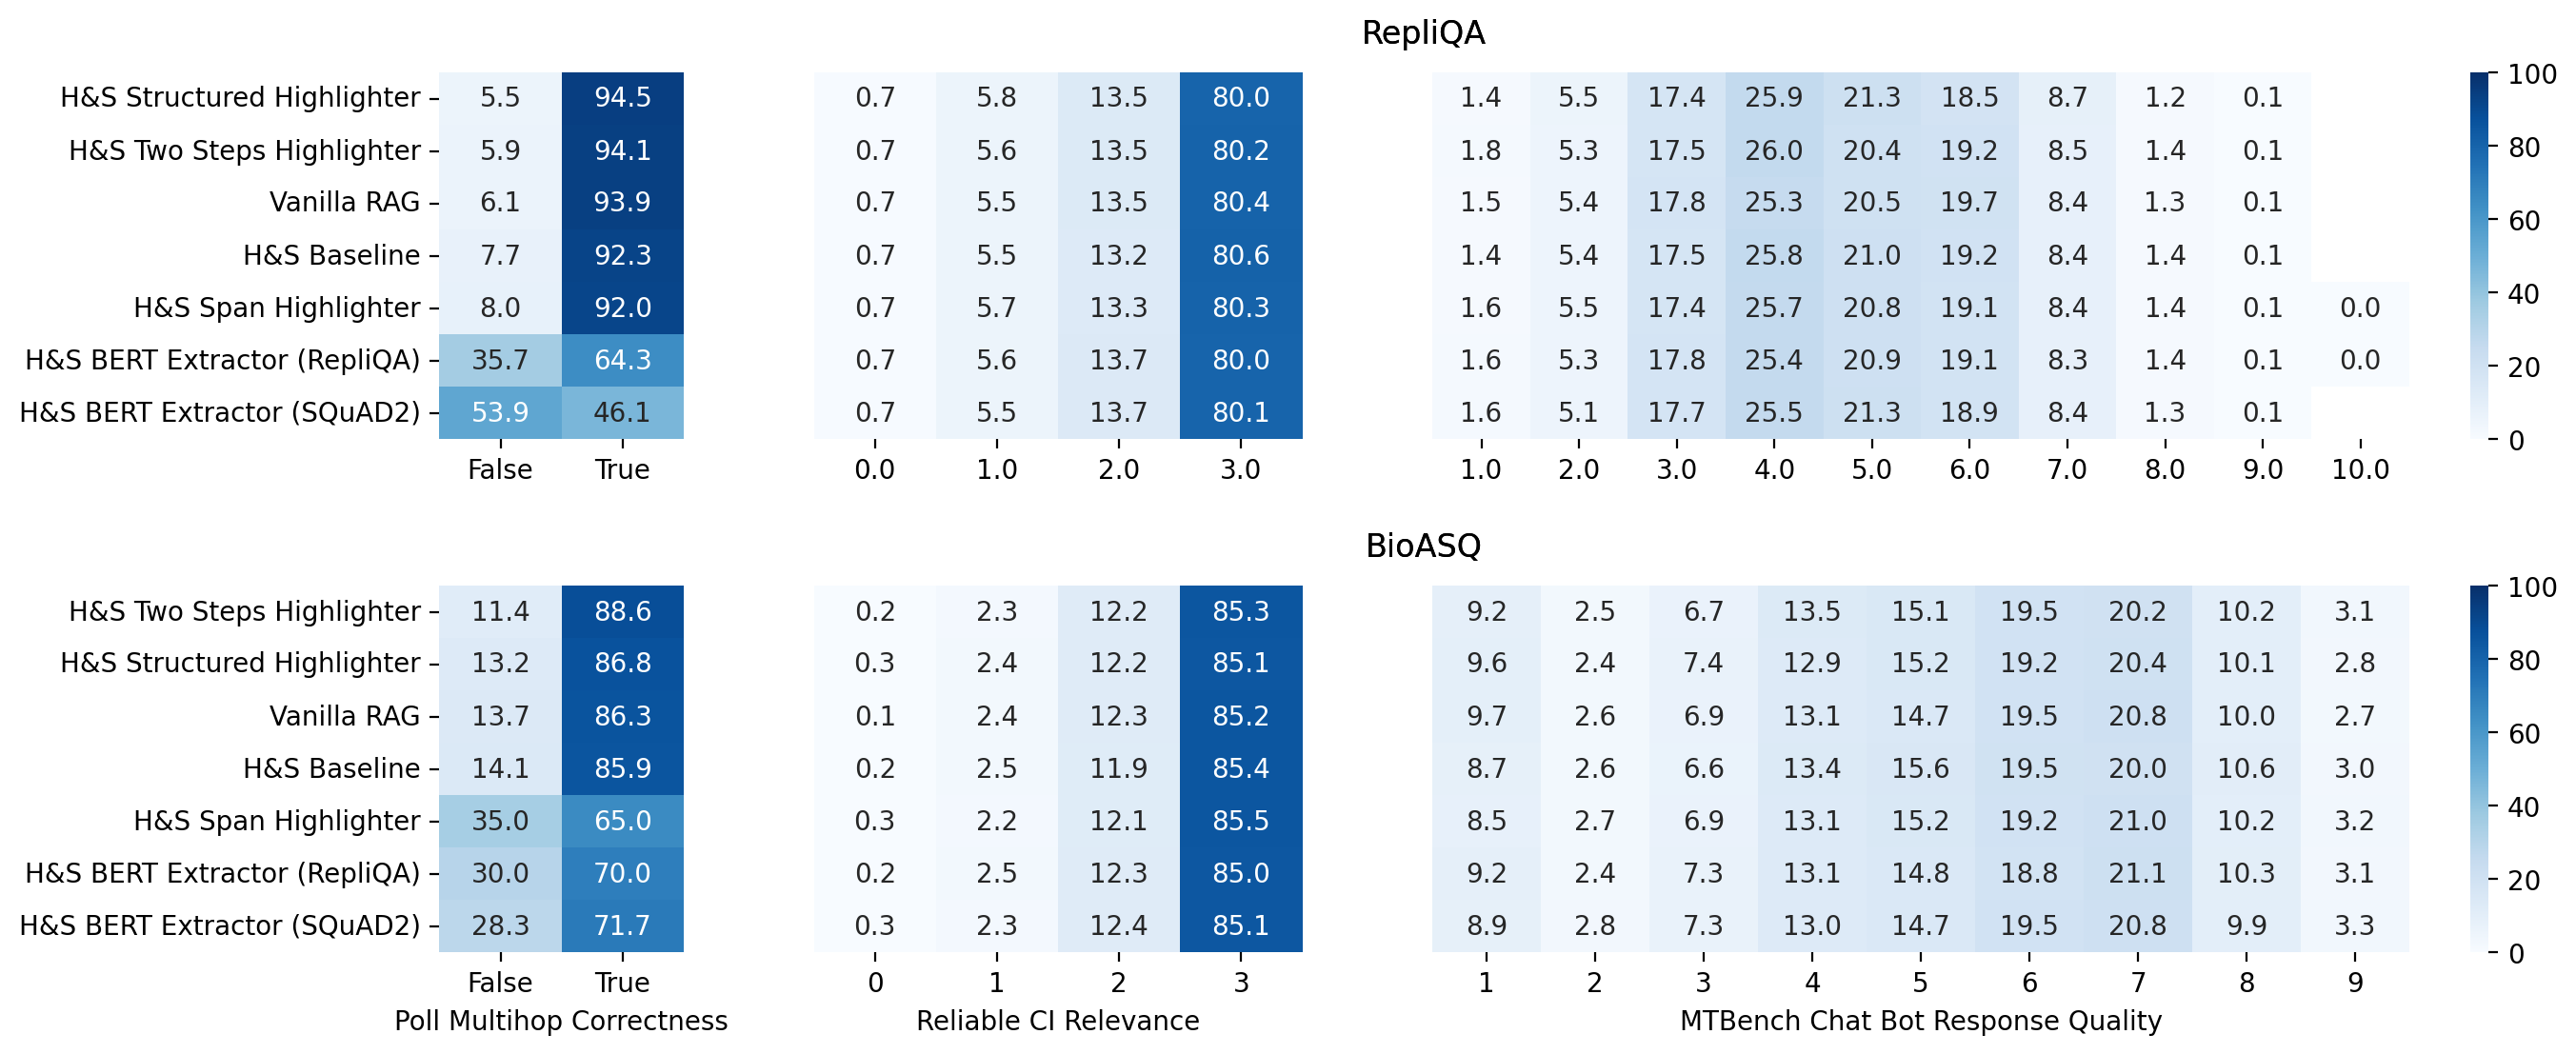

In [13]:
fig = plt.figure(figsize=(15, 6), dpi=200)
# 2 rows (datasets), 3 columns (judges) with width ratios proportional to number of values
gs = fig.add_gridspec(2, 3, width_ratios=[2, 4, 10], hspace=0.4)

judges = ["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating", "ReliableCIRelevance-gpt-4.1-mini_quality_rating", "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating"]

# Store axes for adding centered titles later
row_axes = {0: [], 1: []}

for row_idx, (dataset_name, dataset_results) in enumerate(results_df.items()):
    print(f"Dataset: {dataset_name}")
    df = dataset_results[dataset_results.answer != NOANSWER_PRED]

    for col_idx, judge in enumerate(judges):
        df_relevance = {}
        for run_id, group in df.groupby("run_id"):
            df_relevance[run_id] = group.value_counts(judge).rename_axis("rating").reset_index(name="count")
        df_relevance = pd.concat(df_relevance, names=["run_id"]).reset_index()
        df_relevance["run_id"] = df_relevance["run_id"].map(PRETTY_NAMES)
        df_relevance.sort_values("count", ascending=False, inplace=True)
        df_relevance_pivot = df_relevance.pivot(index="run_id", columns="rating", values="count")
        
        # Normalize each row to percentages (sum to 100%)
        df_relevance_pivot = df_relevance_pivot.div(df_relevance_pivot.sum(axis=1), axis=0) * 100
        
        # Sort by our preferred order.
        if dataset_name == "repliqa_3":
            df_relevance_pivot = df_relevance_pivot.reindex([
                    "H&S Structured Highlighter",
                    "H&S Two Steps Highlighter",
                    "Vanilla RAG",
                    "H&S Baseline",
                    "H&S Span Highlighter",
                    "H&S BERT Extractor (RepliQA)",
                    "H&S BERT Extractor (SQuAD2)",
                ],
                axis=0,
            )
        else:
            df_relevance_pivot = df_relevance_pivot.reindex([
                    "H&S Two Steps Highlighter",
                    "H&S Structured Highlighter",
                    "Vanilla RAG",
                    "H&S Baseline",
                    "H&S Span Highlighter",
                    "H&S BERT Extractor (RepliQA)",
                    "H&S BERT Extractor (SQuAD2)",
                ],
                axis=0,
            )

        ax = fig.add_subplot(gs[row_idx, col_idx])
        row_axes[row_idx].append(ax)
        
        # Only show y-axis labels on first column
        if col_idx > 0:
            ax.tick_params(axis='y', left=False, labelleft=False)
        
        # Only show colorbar on the last column
        cbar = (col_idx == 2)

        sns.heatmap(
            data=df_relevance_pivot,
            annot=True,
            fmt=".1f",
            cmap="Blues",
            cbar=cbar,
            vmin=0,
            vmax=100,
            ax=ax,
        )
        
        # Only show x-label (judge name) on bottom row
        if row_idx == 1:
            ax.set_xlabel(PRETTY_NAMES.get(judge, judge))
        else:
            ax.set_xlabel("")
        
        ax.set_ylabel("")

# Add centered titles for each row
for row_idx, (dataset_name, _) in enumerate(results_df.items()):
    # Get the bounding box spanning all axes in this row
    axes_in_row = row_axes[row_idx]
    left = axes_in_row[0].get_position().x0
    right = axes_in_row[-1].get_position().x1
    top = axes_in_row[0].get_position().y1
    center_x = (left + right) / 2
    fig.text(center_x, top + 0.02, PRETTY_NAMES.get(dataset_name, dataset_name), 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()

# Re-add centered titles after tight_layout (positions may have changed)
for row_idx, (dataset_name, _) in enumerate(results_df.items()):
    axes_in_row = row_axes[row_idx]
    left = axes_in_row[0].get_position().x0
    right = axes_in_row[-1].get_position().x1
    top = axes_in_row[0].get_position().y1
    center_x = (left + right) / 2
    fig.text(center_x, top + 0.02, PRETTY_NAMES.get(dataset_name, dataset_name), 
             ha='center', va='bottom', fontsize=12)

#### Figure 4


Dataset: RepliQA

Wins (includes ties) per judge:
                                   H&S Structured  H&S Two Steps  Vanilla RAG  H&S Baseline  H&S Span  H&S DeBERTav3 (RepliQA)  H&S DeBERTav3 (SQuAD2)
Poll Multihop Correctness                   81103          80798        80285         79469     79262                    56680                   41119
Reliable CI Relevance                       78973          79013        79395         79367     79177                    78429                   74248
MTBench Chat Bot Response Quality           65008          65065        65297         65430     65198                    60023                   57869

Total wins across all judges:
  H&S Structured: 225084
  Vanilla RAG: 224977
  H&S Two Steps: 224876
  H&S Baseline: 224266
  H&S Span: 223637
  H&S DeBERTav3 (RepliQA): 195132
  H&S DeBERTav3 (SQuAD2): 173236

Dataset: BioASQ

Wins (includes ties) per judge:
                                   H&S Structured  H&S Two Steps  Vanilla RAG  H&S B

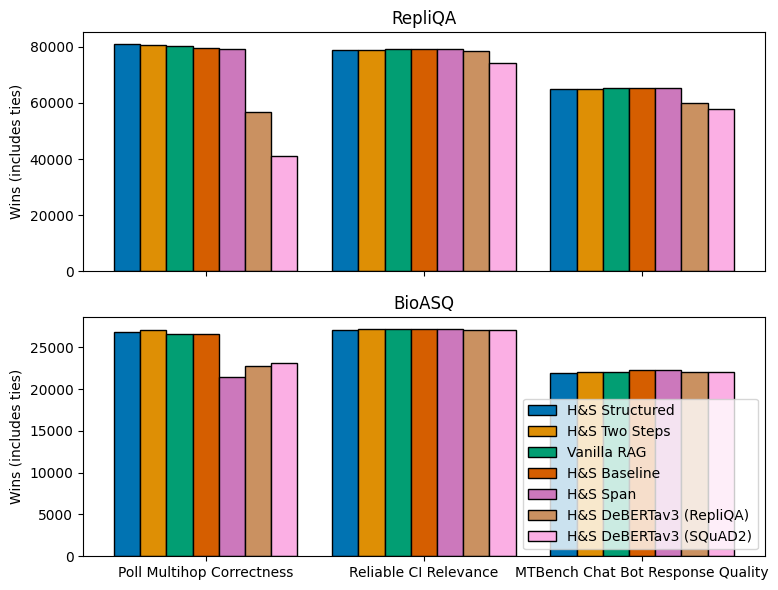

In [14]:
# Count pairwise wins (including ties) for each pipeline per judge
judges = [
    "PollMultihopCorrectness-gpt-4.1-mini_correctness_rating",
    "ReliableCIRelevance-gpt-4.1-mini_quality_rating",
    "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating"
]
judge_short_names = {
    "PollMultihopCorrectness-gpt-4.1-mini_correctness_rating": "Poll Multihop Correctness",
    "ReliableCIRelevance-gpt-4.1-mini_quality_rating": "Reliable CI Relevance",
    "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating": "MTBench Chat Bot Response Quality"
}

pipeline_names_for_plot = {
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Structured",
    "HSSpanHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Span",
    "HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Two Steps",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini": "H&S Baseline",
    "QAEvaluator-gpt-4.1-mini": "Vanilla RAG",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini": "H&S DeBERTav3 (RepliQA)",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini": "H&S DeBERTav3 (SQuAD2)",
}

# Define the order for pipelines
pipeline_order = [
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini",
    "HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini",
    "QAEvaluator-gpt-4.1-mini",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini",
    "HSSpanHighlighter-gpt-4.1-mini-gpt-4.1-mini",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini",
]

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for ax, (dataset_name, dataset_results) in zip(axes, results_df.items()):
    df = dataset_results[dataset_results.answer != NOANSWER_PRED].copy()

    # Get unique pipelines in the specified order
    pipelines = [p for p in pipeline_order if p in df.run_id.unique()]

    # Determine the question ID column
    question_id_col = "question_id" if "question_id" in df.columns else "id"

    wins_data = {judge: {p: 0 for p in pipelines} for judge in judges}

    for judge in judges:
        # Group by question to compare pipelines on same questions
        for qid, group in df.groupby(question_id_col):
            # Get scores for each pipeline on this question
            scores = {}
            for _, row in group.iterrows():
                if row["run_id"] in pipelines:
                    scores[row["run_id"]] = row[judge]

            # Count pairwise wins (including ties)
            for p1 in scores:
                for p2 in scores:
                    if p1 != p2 and scores[p1] is not None and scores[p2] is not None and not pd.isnull(scores[p1]) and not pd.isnull(scores[p2]):
                        if scores[p1] >= scores[p2]:
                            wins_data[judge][p1] += 1

    # Print wins stats for this dataset
    print(f"\n{'='*80}")
    print(f"Dataset: {PRETTY_NAMES.get(dataset_name, dataset_name)}")
    print(f"{'='*80}")
    
    # Create a DataFrame for better formatting
    wins_df = pd.DataFrame(wins_data).T
    wins_df.columns = [pipeline_names_for_plot[p] for p in wins_df.columns]
    wins_df.index = [judge_short_names[j] for j in wins_df.index]
    print("\nWins (includes ties) per judge:")
    print(wins_df.to_string())
    
    # Print totals
    print("\nTotal wins across all judges:")
    totals = {pipeline_names_for_plot[p]: sum(wins_data[j][p] for j in judges) for p in pipelines}
    for pipeline, total in sorted(totals.items(), key=lambda x: x[1], reverse=True):
        print(f"  {pipeline}: {total}")

    # Prepare data for plotting
    x = np.arange(len(judges))
    width = 0.12

    for i, pipeline in enumerate(pipelines):
        wins = [wins_data[judge][pipeline] for judge in judges]
        offset = (i - len(pipelines) / 2 + 0.5) * width
        ax.bar(x + offset, wins, width, label=pipeline_names_for_plot[pipeline], edgecolor='black')

    ax.set_ylabel("Wins (includes ties)")
    ax.set_title(PRETTY_NAMES.get(dataset_name, dataset_name))
    ax.set_xticks(x)
    ax.set_xticklabels([judge_short_names[j] for j in judges])

axes[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

### Unanswerable questions (Table 5)

In [15]:
df = results_df["repliqa_3"]

def unanswerable_precision(df):
    """When the pipeline predicts NOANSWER_PRED, how many of the answers are actually unanswerable?"""
    predicts_unanswerable = df.answer_pred == NOANSWER_PRED
    total = predicts_unanswerable.sum()
    if total == 0:
        return 0.0
    predicts_unanswerable_correct = predicts_unanswerable & (df.answer == NOANSWER_PRED)

    return np.sum(predicts_unanswerable_correct) / total

def unanswerable_recall(df):
    """When the answer is unanswerable, how many times does the pipeline predict NOANSWER_PRED?"""
    unanswerable = df.answer == NOANSWER_PRED
    total = unanswerable.sum()
    if total == 0:
        return 0.0
    predicts_unanswerable_correct = unanswerable & (df.answer_pred == NOANSWER_PRED)

    return np.sum(predicts_unanswerable_correct) / total


to_latex(
    df.groupby("run_id").apply(
        lambda x: pd.Series({
            "unanswerable_precision": unanswerable_precision(x),
            "unanswerable_recall": unanswerable_recall(x),
            "unanswerable_f1": 2 / (unanswerable_precision(x)**-1 + unanswerable_recall(x)**-1)
        })
    ).reset_index(),
    columns=["unanswerable_precision", "unanswerable_recall", "unanswerable_f1"],
    sort_by="unanswerable_f1",
    ascending=False
)

\begin{tabular}{lrrr}
\toprule
Run ID & unanswerable\_precision & unanswerable\_recall & unanswerable\_f1 \\
\midrule
H\&S BERT Extractor (RepliQA) & 0.85 & 0.99 & 0.91 \\
H\&S Structured Highlighter & 0.94 & 0.40 & 0.57 \\
H\&S Span Highlighter & 0.76 & 0.43 & 0.55 \\
H\&S BERT Extractor (SQuAD2) & 0.55 & 0.48 & 0.51 \\
Vanilla RAG & 0.94 & 0.24 & 0.38 \\
H\&S Baseline & 0.60 & 0.20 & 0.30 \\
H\&S Two Steps Highlighter & 0.45 & 0.01 & 0.03 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3084304/3228191477.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("run_id").apply(
/tmp/ipykernel_3084304/3429809249.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


### The effect of min_words (Figure 6)

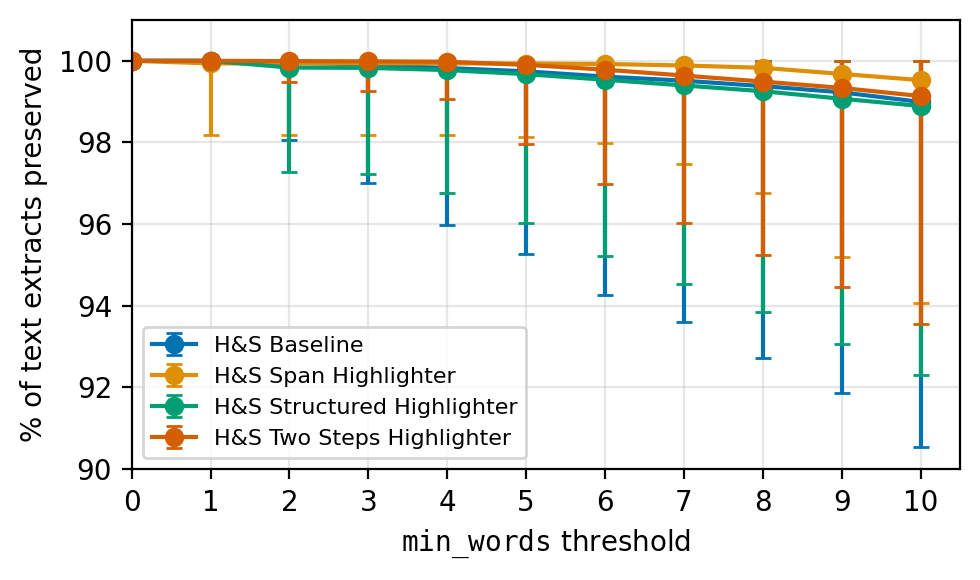

[{'min_words': 0,
  'pipeline': 'HSBaseline',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 0,
  'pipeline': 'HSSpanHighlighter',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 0,
  'pipeline': 'HSStructuredHighlighter',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 0,
  'pipeline': 'HSTwoStepsHighlighter',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 1,
  'pipeline': 'HSBaseline',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 1,
  'pipeline': 'HSSpanHighlighter',
  'mean': np.float64(99.93744698897372),
  'std': np.float64(1.7574394622124903)},
 {'min_words': 1,
  'pipeline': 'HSStructuredHighlighter',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 1,
  'pipeline': 'HSTwoStepsHighlighter',
  'mean': np.float64(100.0),
  'std': np.float64(0.0)},
 {'min_words': 2,
  'pipeline': 'HSBaseline',
  'mean': np.float64(99.96227072208033),
  'std':

In [35]:
# Effect of min_words on text extract preservation (Figure 6)

df_hs = results_df["repliqa_3"].query("pipeline not in ['QAEvaluator', 'HSBERTExtractor']").copy()
df_hs = df_hs[df_hs["highlighter_text_extracts"].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 0)]

def get_extracts(row):
    """Get full text extracts. SpanHighlighter stores 'start...end' abbreviated format, so reconstruct from highlighter_extracted."""
    extracts = row["highlighter_text_extracts"]
    if row["pipeline"] != "HSSpanHighlighter":
        return [str(e) for e in extracts if e and not pd.isna(e)]
    # Reconstruct SpanHighlighter full text from highlighter_extracted
    extracted = str(row["highlighter_extracted"]) if row["highlighter_extracted"] and not pd.isna(row["highlighter_extracted"]) else ""
    full = []
    for e in extracts:
        if not e or pd.isna(e): continue
        s = str(e)
        if "..." in s:
            start, end = s.split("...")[0].strip(), s.split("...")[-1].strip()
            i, j = extracted.find(start), extracted.find(end)
            if i != -1 and j != -1: full.append(extracted[i:j+len(end)].strip())
        else:
            full.append(s.strip())
    return full

def preservation_rate(extracts, min_words):
    """Compute % of extracts with >= min_words words."""
    words = [len(e.split()) for e in extracts]
    return 100 * sum(w >= min_words for w in words) / len(words) if words else np.nan

df_hs["extracts"] = df_hs.apply(get_extracts, axis=1)

# Aggregate mean/std preservation rate per pipeline per min_words threshold
stats = []
for min_words in range(11):
    for pipeline, grp in df_hs.groupby("pipeline"):
        rates = grp["extracts"].apply(lambda x: preservation_rate(x, min_words)).dropna()
        stats.append({"min_words": min_words, "pipeline": pipeline, "mean": rates.mean(), "std": rates.std()})
stats_df = pd.DataFrame(stats)

# Plot
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
for i, (pipeline, grp) in enumerate(stats_df.groupby("pipeline")):
    label = PRETTY_NAMES.get(f"{pipeline}-gpt-4.1-mini-gpt-4.1-mini", pipeline)
    # Asymmetric error bars: full std downward, clipped to 100 upward
    lower_err = grp["std"].values
    upper_err = np.minimum(grp["std"].values, 100 - grp["mean"].values)
    ax.errorbar(grp["min_words"], grp["mean"], yerr=[lower_err, upper_err], label=label, marker='o', capsize=3, color=PALETTE[i])

ax.set(xlabel=r"$\mathtt{min\_words}$ threshold", ylabel="% of text extracts preserved",
       xticks=range(11), ylim=(90, 101), xlim=(0, 10.5))
ax.legend(loc='lower left', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
stats

### Time comparison (Table 8)

In [17]:
# Parse run.txt files and produce a timing table
import re
from pathlib import Path

def parse_timing_results(results_dir):
    """Parse all run.txt files in a results directory and return timing data."""
    results_path = Path(results_dir)
    timing_data = []
    
    for pipeline_dir in results_path.iterdir():
        if not pipeline_dir.is_dir():
            continue
        
        run_txt = pipeline_dir / "run.txt"
        if not run_txt.exists():
            continue
        
        with open(run_txt, "r") as f:
            content = f.read()
        
        # Extract average time: "Average: X.XX seconds per example"
        match = re.search(r"Average:\s*([\d.]+)\s*seconds per example", content)
        if match:
            avg_time = float(match.group(1))
            pipeline_name = pipeline_dir.name
            # Map to pretty name
            pretty_name = PRETTY_NAMES.get(pipeline_name, pipeline_name)
            timing_data.append({
                "Pipeline": pretty_name,
                "Time (s)": avg_time,
            })
    
    return pd.DataFrame(timing_data).sort_values("Time (s)").reset_index(drop=True)

# Generate timing table for repliqa_3
timing_df = parse_timing_results("results/repliqa_3-subsampled")

# LaTeX table
print("\n% LaTeX Table")
print("\\begin{table}")
print("\\caption{Processing time for one question, averaged over the dataset.}")
print("\\label{tab:timing}")
print("\\begin{tabular}{lr}")
print("\\toprule")
print("Pipeline & Time (s) \\\\")
print("\\midrule")
for _, row in timing_df.iterrows():
    pipeline = row["Pipeline"].replace("&", "\\&")
    time_val = row["Time (s)"]
    print(f"{pipeline} & {time_val:.2f} \\\\")
print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")


% LaTeX Table
\begin{table}
\caption{Processing time for one question, averaged over the dataset.}
\label{tab:timing}
\begin{tabular}{lr}
\toprule
Pipeline & Time (s) \\
\midrule
Vanilla RAG & 0.78 \\
H\&S BERT Extractor (RepliQA) & 1.68 \\
H\&S BERT Extractor (SQuAD2) & 2.00 \\
H\&S Span Highlighter & 4.19 \\
H\&S Baseline & 4.62 \\
H\&S Structured Highlighter & 5.89 \\
H\&S Two Steps Highlighter & 8.66 \\
\bottomrule
\end{tabular}
\end{table}


# Pairwise comparisons

Load and convert to "battles" format for easier parsing.

In [18]:
def load_battles(dataset_name):
    dataset_results = f"{RESULTS_DIR}/{dataset_name}"
    battles = []
    for comparison in os.listdir(dataset_results):
        if not comparison.startswith("comparison-") or comparison.endswith("highlighter_vs_hs.jsonl"):
            continue
        model_a, model_b = comparison[len("comparison-"):-len(".jsonl")].split("_vs_")
        print(f"Processing comparison: {model_a} vs {model_b}")
        df = pd.read_json(os.path.join(dataset_results, comparison), lines=True)
        for _, row in df.iterrows():
            if row["preference"] == "neither":
                winner = "tie (bothbad)"
            elif row["preference"] in [model_a, model_b]:
                winner = "model_a" if row["preference"] == model_a else "model_b"
            elif row["preference"] == "tie":
                winner = "tie"
            else:
                raise ValueError(f"Unexpected preference value: {row['preference']}")

            battles.append({
                "model_a": model_a,
                "model_b": model_b,
                "winner": winner,
            })
    battles = pd.DataFrame(battles)
    all_models = pd.concat([battles["model_a"], battles["model_b"]]).unique()
    print(f"All models: {', '.join(all_models)}")
    return battles, all_models

def compute_battles_stats(battles, all_models):
    counts = {}
    for model in all_models:
        counts[model] = {}
        for other_model in all_models:
            if model == other_model:
                continue
            wins = ties = losses = 0
            # model is model_a, other_model is model_b.
            battles_for_pair = battles[(battles.model_a == model) & (battles.model_b == other_model)]
            wins += (battles_for_pair.winner == "model_a").sum()
            ties += ((battles_for_pair.winner == "tie") | (battles_for_pair.winner == "tie (bothbad)")).sum()
            losses += (battles_for_pair.winner == "model_b").sum()
            # model is model_b, other_model is model_a.
            battles_for_pair = battles[(battles.model_a == other_model) & (battles.model_b == model)]
            wins += (battles_for_pair.winner == "model_b").sum()
            ties += ((battles_for_pair.winner == "tie") | (battles_for_pair.winner == "tie (bothbad)")).sum()
            losses += (battles_for_pair.winner == "model_a").sum()

            counts[model][other_model] = {
                "wins": wins,
                "losses": losses,
                "ties": ties,
                "total": wins + losses + ties,
            }
    return counts

In [19]:
battles = {}
battles_stats = {}
for dataset_name in ["repliqa_3", "bioasq"]:
    b, all_models = load_battles(dataset_name)
    battles[dataset_name] = b
    battles_stats[dataset_name] = compute_battles_stats(b, all_models)

Processing comparison: HSSpanHighlighter-gpt-4.1-mini-gpt-4.1-mini vs HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: HSBaseline-gpt-4.1-mini-gpt-4.1-mini vs HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini vs HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini vs HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini vs QAEvaluator-gpt-4.1-mini
Processing comparison: HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini vs QAEvaluator-gpt-4.1-mini
Processing comparison: HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini vs QAEvaluator-gpt-4.1-mini
Processing comparison: HSBERTExtractor-models_microsoft-de

### Wins heatmap (Figure 3)

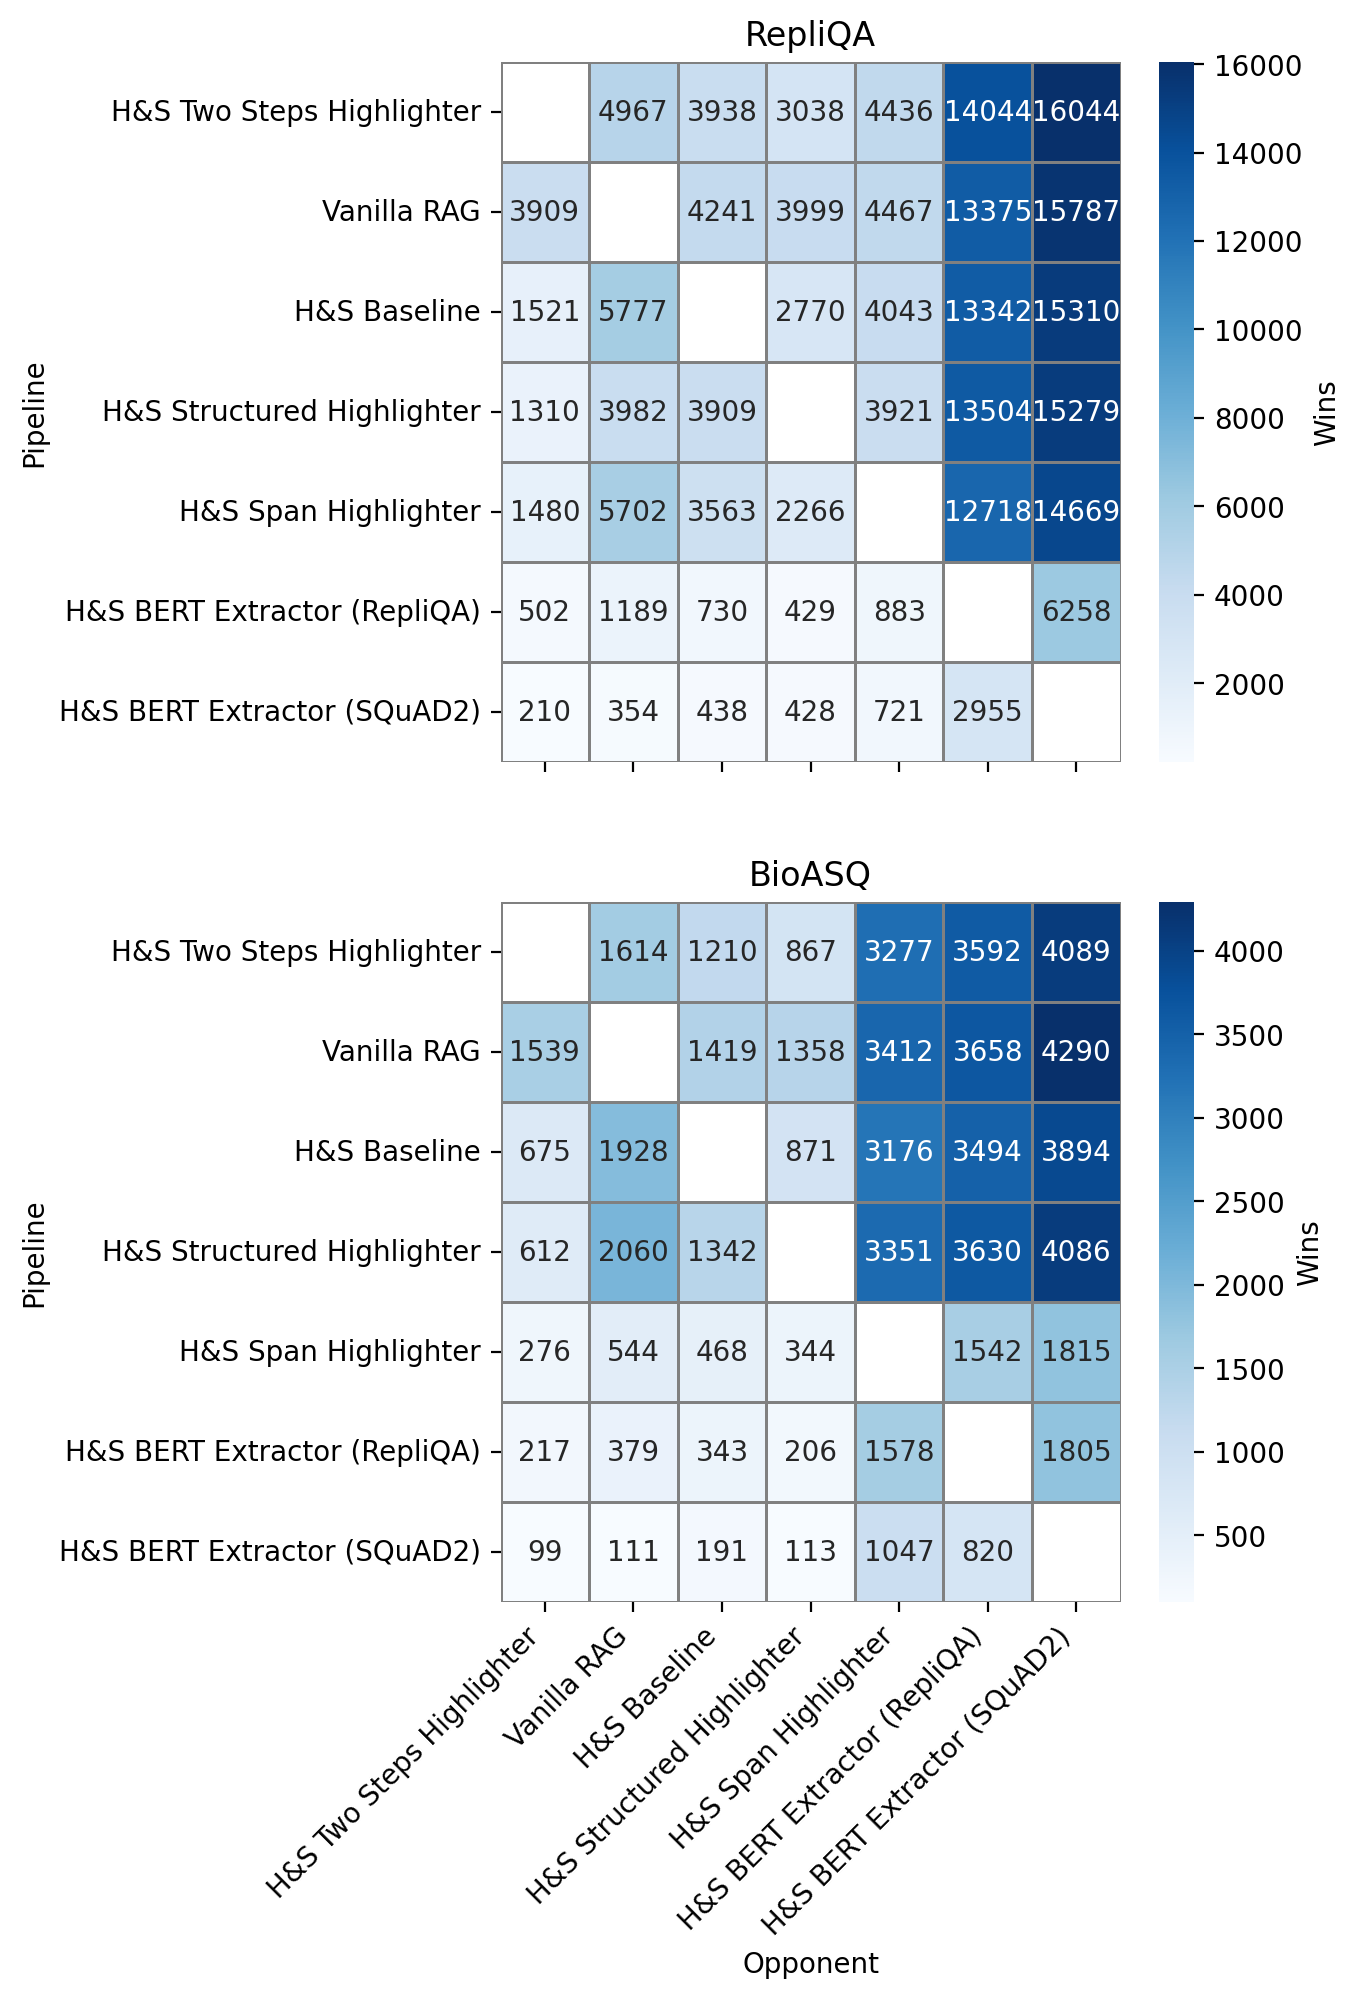

In [20]:
def battles_heatmap(battles_stats):
    all_models = list(battles_stats.keys())
    wins_matrix = pd.DataFrame(
        index=[PRETTY_NAMES[m] for m in all_models],
        columns=[PRETTY_NAMES[m] for m in all_models],
        data=0
    )

    for model in all_models:
        for other_model in all_models:
            if model == other_model:
                wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = None
            else:
                wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = battles_stats[model][other_model]["wins"]

    plt.figure(figsize=(8, 6), dpi=200)
    sns.heatmap(
        wins_matrix.astype(float),
        annot=True,
        fmt=".0f",
        cmap="Blues",
        cbar_kws={'label': 'Wins'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title("Pairwise Wins")
    plt.xlabel("Opponent")
    plt.ylabel("Pipeline")
    plt.tight_layout()

def battles_heatmap_joint(battles_stats):
    fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True, dpi=200)

    for ax, dataset_name in zip(axes, battles_stats.keys()):
        #all_models = list(battles_stats[dataset_name].keys())
        # Force our ordering:
        all_models = [
            'HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini',
            'QAEvaluator-gpt-4.1-mini',
            'HSBaseline-gpt-4.1-mini-gpt-4.1-mini',
            'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini',
            'HSSpanHighlighter-gpt-4.1-mini-gpt-4.1-mini',
            'HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini',
            'HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini',
        ]
        wins_matrix = pd.DataFrame(
            index=[PRETTY_NAMES[m] for m in all_models],
            columns=[PRETTY_NAMES[m] for m in all_models],
            data=0
        )

        for model in all_models:
            for other_model in all_models:
                if model == other_model:
                    wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = None
                else:
                    wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = battles_stats[dataset_name][model][other_model]["wins"]

        sns.heatmap(
            wins_matrix.astype(float),
            annot=True,
            fmt=".0f",
            cmap="Blues",
            cbar_kws={'label': 'Wins'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax
        )
        ax.set_title(f"{PRETTY_NAMES[dataset_name]}")
        if ax == axes[1]:
            ax.set_xlabel("Opponent")
        else:
            ax.set_xticks([])
        ax.set_ylabel("Pipeline")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# for dataset_name in battles_stats:
#     print(f"Dataset: {dataset_name}")
#     battles_heatmap(battles_stats[dataset_name])
battles_heatmap_joint(battles_stats)

### Elo (Table 3)

In [21]:
def wins_elo_table(battles, battles_stats):
    all_models = list(battles_stats.keys())

    # Compute win rate using standard Elo scoring: win=1, tie=0.5, loss=0
    total_wins = {model: 0 for model in all_models}
    average_wins = {model: 0 for model in all_models}
    for model in all_models:
        num_battles_for_model = 0
        for other_model in all_models:
            if model == other_model:
                continue
            total_wins[model] += battles_stats[model][other_model]["wins"] + 0.5 * battles_stats[model][other_model]["ties"]
            num_battles_for_model += battles_stats[model][other_model]["total"]
        average_wins[model] = total_wins[model] / num_battles_for_model

    elo = compute_elo(battles)
    return average_wins, elo

# Compute stats for all datasets
all_results = {}
for dataset_name in battles_stats:
    avg_wins, elo = wins_elo_table(battles[dataset_name], battles_stats[dataset_name])
    all_results[dataset_name] = {"average_wins": avg_wins, "elo": elo}

# Generate combined LaTeX table
print("\\begin{table}")
print("\\caption{Direct pairwise comparison of all pipelines by the ComparisonJudge LLM. Win rate uses standard Elo scoring (win=1, tie=0.5, loss=0).}")
print("\\label{tab:average_wins}")
print("\\begin{tabular}{lllr}")
print("\\toprule")
print("& & Elo Score & Wins\\\\")
print("\\midrule")

for i, dataset_name in enumerate(all_results):
    avg_wins = all_results[dataset_name]["average_wins"]
    elo = all_results[dataset_name]["elo"]
    
    # Sort by Elo score descending
    sorted_models = sorted(elo.keys(), key=lambda x: elo[x], reverse=True)
    n_models = len(sorted_models)
    
    dataset_pretty = PRETTY_NAMES.get(dataset_name, dataset_name).replace("&", "\\&")
    
    for j, model in enumerate(sorted_models):
        model_pretty = PRETTY_NAMES.get(model, model).replace("&", "\\&")
        wins_pct = f"{avg_wins[model]*100:.0f}\\%"
        elo_score = int(elo[model])
        
        if j == 0:
            print(f"\\multirow{{{n_models}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{dataset_pretty}}}}}")
        print(f"& {model_pretty} & {elo_score} & {wins_pct} \\\\")
    
    if i < len(all_results) - 1:
        print("\\midrule")

print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

\begin{table}
\caption{Direct pairwise comparison of all pipelines by the ComparisonJudge LLM. Win rate uses standard Elo scoring (win=1, tie=0.5, loss=0).}
\label{tab:average_wins}
\begin{tabular}{lllr}
\toprule
& & Elo Score & Wins\\
\midrule
\multirow{7}{*}{\rotatebox[origin=c]{90}{RepliQA}}
& H\&S Span Highlighter & 1170 & 60\% \\
& H\&S Baseline & 1145 & 62\% \\
& H\&S Structured Highlighter & 1105 & 63\% \\
& Vanilla RAG & 1104 & 61\% \\
& H\&S Two Steps Highlighter & 1098 & 67\% \\
& H\&S BERT Extractor (RepliQA) & 702 & 22\% \\
& H\&S BERT Extractor (SQuAD2) & 673 & 14\% \\
\midrule
\multirow{7}{*}{\rotatebox[origin=c]{90}{BioASQ}}
& Vanilla RAG & 1197 & 66\% \\
& H\&S Structured Highlighter & 1181 & 70\% \\
& H\&S Two Steps Highlighter & 1104 & 70\% \\
& H\&S Baseline & 1099 & 66\% \\
& H\&S Span Highlighter & 854 & 31\% \\
& H\&S BERT Extractor (RepliQA) & 799 & 28\% \\
& H\&S BERT Extractor (SQuAD2) & 762 & 19\% \\
\bottomrule
\end{tabular}
\end{table}


### Detailed table (Table 9)

In [22]:
SHORT_NAMES = {
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini": "Structured",
    "HSSpanHighlighter-gpt-4.1-mini-gpt-4.1-mini": "Span",
    "HSTwoStepsHighlighter-gpt-4.1-mini-gpt-4.1-mini": "Two Steps",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini": "Baseline",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini": "BERT (RepliQA)",
    "QAEvaluator-gpt-4.1-mini": "Vanilla",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini": "BERT (SQuAD2)",
}

def detailed_wins_table_combined(all_battles_stats):
    """Generate a single combined LaTeX table for all datasets."""
    # Get all models from first dataset (assume same models in all datasets)
    first_dataset = list(all_battles_stats.keys())[0]
    all_models = list(all_battles_stats[first_dataset].keys())
    
    # Build header
    opponent_cols = [SHORT_NAMES[m] for m in all_models]
    header_row1 = " & ".join(["", ""] + [f"\\multicolumn{{2}}{{c}}{{{col}}}" for col in opponent_cols] + ["\\multicolumn{2}{c}{Total}"])
    header_row2 = " & ".join(["", ""] + ["W", "T"] * (len(all_models) + 1))
    
    print("\\begin{table}")
    print("\\caption{Pairwise battle results: Each cell shows Wins (W) and Ties (T) for the row model vs the column model.}")
    print("\\label{tab:battle_results}")
    print("\\footnotesize")
    print("\\begin{tabular}{ll" + "rr" * (len(all_models) + 1) + "}")
    print("\\toprule")
    print(header_row1 + " \\\\")
    print("\\cmidrule(lr){3-" + str(2 + 2*len(all_models)) + "} \\cmidrule(lr){" + str(3 + 2*len(all_models)) + "-" + str(4 + 2*len(all_models)) + "}")
    print(header_row2 + " \\\\")
    print("\\midrule")
    
    for i, (dataset_name, battles_stats) in enumerate(all_battles_stats.items()):
        n_models = len(all_models)
        dataset_pretty = PRETTY_NAMES.get(dataset_name, dataset_name).replace("&", "\\&")
        
        for j, model in enumerate(all_models):
            row_data = []
            total_wins = 0
            total_ties = 0
            
            for other_model in all_models:
                if model == other_model:
                    row_data.extend(["--", "--"])
                else:
                    c = battles_stats[model][other_model]
                    row_data.extend([str(c["wins"]), str(c["ties"])])
                    total_wins += c["wins"]
                    total_ties += c["ties"]
            
            row_data.extend([str(total_wins), str(total_ties)])
            model_pretty = SHORT_NAMES.get(model, model).replace("&", "\\&")
            
            if j == 0:
                print(f"\\multirow{{{n_models}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{dataset_pretty}}}}}")
            print(f"& {model_pretty} & " + " & ".join(row_data) + " \\\\")
        
        if i < len(all_battles_stats) - 1:
            print("\\midrule")
    
    print("\\bottomrule")
    print("\\end{tabular}")
    print("\\end{table}")

detailed_wins_table_combined(battles_stats)

\begin{table}
\caption{Pairwise battle results: Each cell shows Wins (W) and Ties (T) for the row model vs the column model.}
\label{tab:battle_results}
\footnotesize
\begin{tabular}{llrrrrrrrrrrrrrrrr}
\toprule
 &  & \multicolumn{2}{c}{Span} & \multicolumn{2}{c}{Baseline} & \multicolumn{2}{c}{BERT (SQuAD2)} & \multicolumn{2}{c}{Two Steps} & \multicolumn{2}{c}{Structured} & \multicolumn{2}{c}{BERT (RepliQA)} & \multicolumn{2}{c}{Vanilla} & \multicolumn{2}{c}{Total} \\
\cmidrule(lr){3-16} \cmidrule(lr){17-18}
 &  & W & T & W & T & W & T & W & T & W & T & W & T & W & T & W & T \\
\midrule
\multirow{7}{*}{\rotatebox[origin=c]{90}{RepliQA}}
& Span & -- & -- & 3563 & 10349 & 14669 & 2565 & 1480 & 12039 & 2266 & 11768 & 12718 & 4354 & 5702 & 7786 & 40398 & 48861 \\
& Baseline & 4043 & 10349 & -- & -- & 15310 & 2207 & 1521 & 12496 & 2770 & 11276 & 13342 & 3883 & 5777 & 7937 & 42763 & 48148 \\
& BERT (SQuAD2) & 721 & 2565 & 438 & 2207 & -- & -- & 210 & 1701 & 428 & 2248 & 2955 & 8742 & 354 & 1

# Costs comparison (Figure 10)

How much do we save (in terms of output tokens) by doing span selection?

Token Usage by Pipeline (highlighter stage only)
Pipeline                  Input (tokens)       Output (tokens)      Calls  N
--------------------------------------------------------------------------------
H&S Baseline                 1254 ± 166           80 ± 63       1      17228
H&S Structured               1255 ± 166           94 ± 83       1      16424
H&S Span                     1255 ± 166           29 ± 22       1      16364
H&S TwoSteps                 2544 ± 333          176 ± 160      2      17955

Note: Two Steps Highlighter sends the context twice (2 LLM calls).
      Its input includes: 2×context + 2×question + intermediate_answer
      Its output includes: intermediate_answer + text_extracts


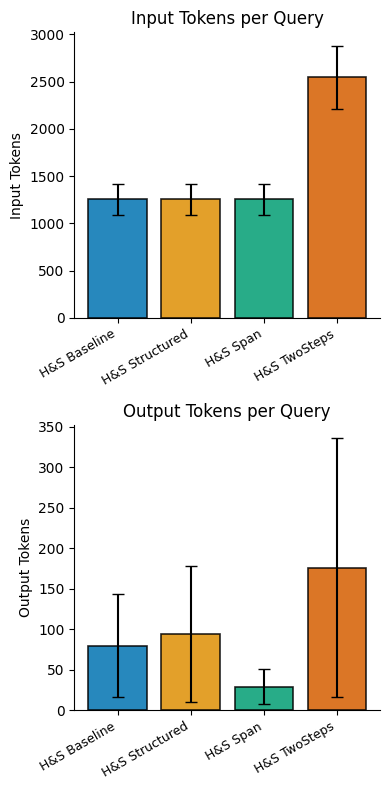

In [23]:
# Measure input and output tokens for each H&S method
# Two Steps Highlighter makes 2 LLM calls, so we account for that

def count_tokens(text):
    """Count tokens using tiktoken."""
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return 0
    return len(enc.encode(str(text)))

def get_extract_tokens(x):
    """Get total tokens from text extracts list."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return 0
    if isinstance(x, (list, np.ndarray)) and len(x) > 0:
        return sum(count_tokens(e) for e in x)
    return 0

# Compute token stats for each pipeline
token_stats = []

for pipeline in ["HSBaseline", "HSStructuredHighlighter", "HSSpanHighlighter", "HSTwoStepsHighlighter"]:
    df_pipe = results_df["repliqa_3"][results_df["repliqa_3"].pipeline == pipeline].copy()
    
    if len(df_pipe) == 0:
        print(f"No data for {pipeline}")
        continue
    
    # Input tokens: context + question (+ prompt overhead, but we ignore that for comparison)
    # For Two Steps: context is sent twice
    context_tokens = df_pipe["document_extracted"].apply(count_tokens)
    question_tokens = df_pipe["question"].apply(count_tokens)
    
    if pipeline == "HSTwoStepsHighlighter":
        # Two Steps: Call 1 (context + question) + Call 2 (context + question + answer)
        # We estimate the intermediate answer as similar to final answer_pred
        answer_tokens = df_pipe["answer_pred"].apply(count_tokens)
        input_tokens = 2 * context_tokens + 2 * question_tokens + answer_tokens
        
        # Output tokens: intermediate answer + extracts
        extract_tokens = df_pipe["highlighter_text_extracts"].apply(get_extract_tokens)
        output_tokens = answer_tokens + extract_tokens  # answer from call 1 + extracts from call 2
    else:
        # Single call highlighters
        input_tokens = context_tokens + question_tokens
        
        # Output tokens: just the extracts (+ answer for Structured, but extracts dominate)
        extract_tokens = df_pipe["highlighter_text_extracts"].apply(get_extract_tokens)
        output_tokens = extract_tokens
    
    # Filter out zeros for meaningful stats
    valid_mask = (input_tokens > 0) & (output_tokens > 0)
    
    token_stats.append({
        "Pipeline": pipeline.replace("HS", "H&S ").replace("Highlighter", "").strip(),
        "Input Mean": input_tokens[valid_mask].mean(),
        "Input Std": input_tokens[valid_mask].std(),
        "Output Mean": output_tokens[valid_mask].mean(),
        "Output Std": output_tokens[valid_mask].std(),
        "N": valid_mask.sum(),
        "LLM Calls": 2 if pipeline == "HSTwoStepsHighlighter" else 1,
    })

df_token_stats = pd.DataFrame(token_stats)

# Display results
print("Token Usage by Pipeline (highlighter stage only)")
print("=" * 80)
print(f"{'Pipeline':<25} {'Input (tokens)':<20} {'Output (tokens)':<20} {'Calls':<6} N")
print("-" * 80)
for _, row in df_token_stats.iterrows():
    print(f"{row['Pipeline']:<25} {row['Input Mean']:>7.0f} ± {row['Input Std']:<8.0f} {row['Output Mean']:>7.0f} ± {row['Output Std']:<8.0f} {row['LLM Calls']:<6} {row['N']}")

print()
print("Note: Two Steps Highlighter sends the context twice (2 LLM calls).")
print("      Its input includes: 2×context + 2×question + intermediate_answer")
print("      Its output includes: intermediate_answer + text_extracts")

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(4, 8))

# Input tokens
ax = axes[0]
x_pos = np.arange(len(df_token_stats))
bars = ax.bar(x_pos, df_token_stats["Input Mean"], yerr=df_token_stats["Input Std"],
              capsize=4, alpha=0.85, edgecolor='black', linewidth=1.2,
              color=[PALETTE[i] for i in range(len(df_token_stats))])
ax.set_xticks(x_pos)
ax.set_xticklabels(df_token_stats["Pipeline"], rotation=30, ha='right', fontsize=9)
ax.set_ylabel("Input Tokens")
ax.set_title("Input Tokens per Query")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Output tokens
ax = axes[1]
bars = ax.bar(x_pos, df_token_stats["Output Mean"], yerr=df_token_stats["Output Std"],
              capsize=4, alpha=0.85, edgecolor='black', linewidth=1.2,
              color=[PALETTE[i] for i in range(len(df_token_stats))])
ax.set_xticks(x_pos)
ax.set_xticklabels(df_token_stats["Pipeline"], rotation=30, ha='right', fontsize=9)
ax.set_ylabel("Output Tokens")
ax.set_title("Output Tokens per Query")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()